In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import subprocess

def convert_file(file_path):


  # Get the file extension.
  extension = os.path.splitext(file_path)[1]

  # Check if the file is an audio file.
  if extension in [".mp3", ".amr", ".m4a", ".mpa", ".aac",".ogg", ".3gpp"]:
    # Convert the file to WAV format.
    subprocess.call([
        "ffmpeg", "-i", file_path, "-c:a", "pcm_s16le", "-ar", "44100", "-ac", "2", "-b:a", "192k", os.path.join(os.path.dirname(file_path), os.path.basename(file_path) + ".wav")
    ])

def convert_folder(folder_path):


  # Get all files in the folder.
  files = os.listdir(folder_path)

  # Convert each file to WAV format.
  for file in files:
    convert_file(os.path.join(folder_path, file))

if __name__ == "__main__":
  # Get the folder path from the user.
  folder_path = "/content/drive/MyDrive/Bengali Accent Classification Dataset/regionData/Formal"

  # Convert all files in the folder to WAV format.
  convert_folder(folder_path)


In [ ]:
import librosa
import os
import pandas as pd

data_dir = '/content/drive/MyDrive/Bengali Accent Classification Dataset/regionData'
accent_folders = os.listdir(data_dir)
print(os.listdir(data_dir))




['Shylet', 'Barishal', 'Mymensingh', 'Dhaka', 'Rajshahi', 'Noakhali', 'Chottogram', 'Khulna', 'Formal']


In [ ]:
data = []

for accent_folder in accent_folders:
    accent_path = os.path.join(data_dir, accent_folder)

    for file in os.listdir(accent_path):
        if file.endswith('.wav'):
            file_path = os.path.join(accent_path, file)
            audio, sr = librosa.load(file_path, sr=None)
            data.append((file_path, accent_folder))

df = pd.DataFrame(data, columns=['Path', 'Region'])

In [ ]:
# changing integers to actual region.
df.Region.replace({1:'Shylet', 2:'Barishal', 3:'Mymensingh', 4:'Dhaka', 5:'Rajshahi', 6:'Noakhali', 7:'Chottogram', 8:'Khulna', 9:'Formal'}, inplace=True)
df.head()

Path  Region
0  /content/drive/MyDrive/Bengali Accent Classifi...  Shylet
1  /content/drive/MyDrive/Bengali Accent Classifi...  Shylet
2  /content/drive/MyDrive/Bengali Accent Classifi...  Shylet
3  /content/drive/MyDrive/Bengali Accent Classifi...  Shylet
4  /content/drive/MyDrive/Bengali Accent Classifi...  Shylet

In [ ]:
df.Region

0       Shylet
1       Shylet
2       Shylet
3       Shylet
4       Shylet
         ...  
9298    Formal
9299    Formal
9300    Formal
9301    Formal
9302    Formal
Name: Region, Length: 9303, dtype: object

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
audio_data= df.Path
labels = df.Region

In [ ]:
audio_data = np.array(audio_data)
labels = np.array(labels)

In [ ]:
audio_data.shape

(9303,)

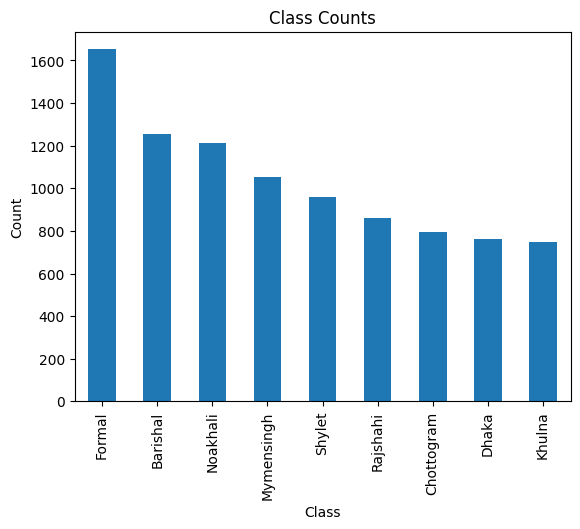

In [ ]:
import matplotlib.pyplot as plt
plt.title('Count of Region Data', size=16)
class_counts = df['Region'].value_counts()

# Plot the class counts using a bar plot
class_counts.plot(kind='bar')
plt.title('Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} Region'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} Region'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

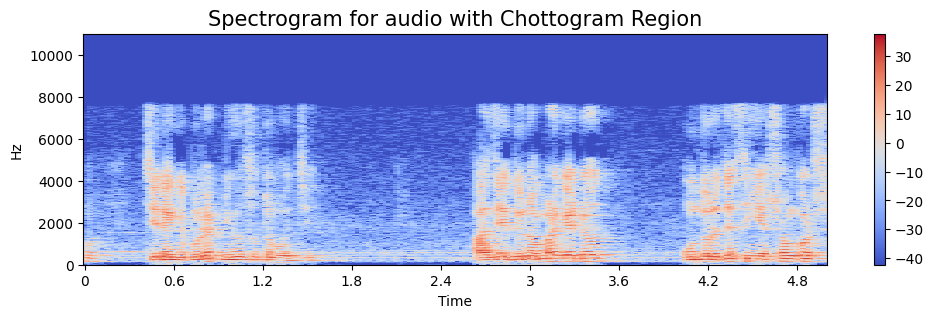

In [ ]:
import librosa
from IPython.display import Audio
region='Chottogram'
path = np.array(df.Path[df.Region==region])[0]
data, sampling_rate = librosa.load(path)
create_spectrogram(data, sampling_rate, region)
Audio(path)

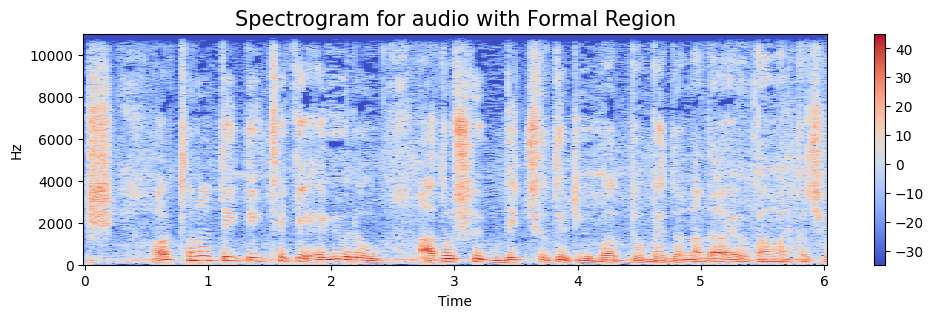

In [ ]:
region='Formal'
path = np.array(df.Path[df.Region==region])[0]
data, sampling_rate = librosa.load(path)
create_spectrogram(data, sampling_rate, region)
Audio(path)

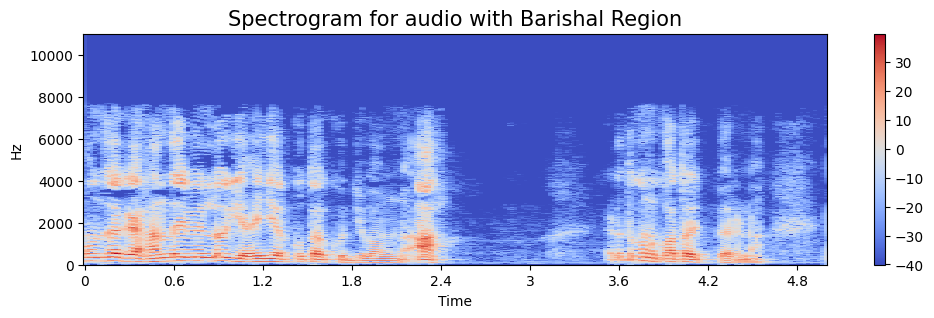

In [ ]:
region='Barishal'
path = np.array(df.Path[df.Region==region])[0]
data, sampling_rate = librosa.load(path)
create_spectrogram(data, sampling_rate, region)
Audio(path)

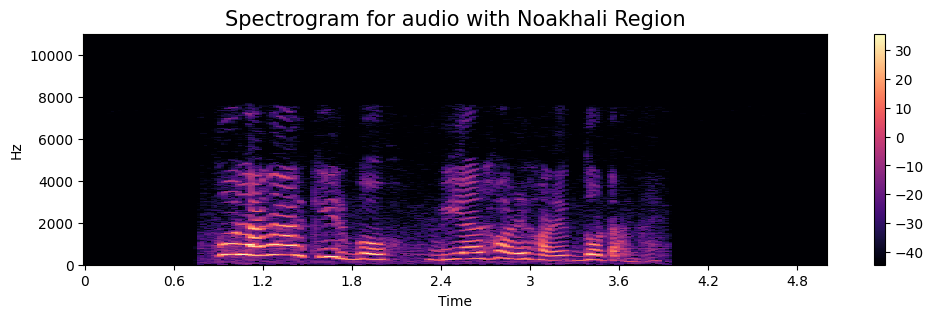

In [ ]:
region='Noakhali'
path = np.array(df.Path[df.Region==region])[0]
data, sampling_rate = librosa.load(path)
create_spectrogram(data, sampling_rate, region)
Audio(path)

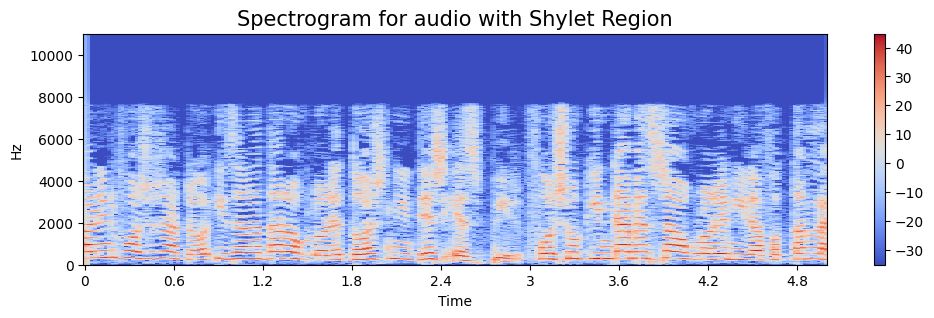

In [ ]:
region='Shylet'
path = np.array(df.Path[df.Region==region])[0]
data, sampling_rate = librosa.load(path)
create_spectrogram(data, sampling_rate, region)
Audio(path)

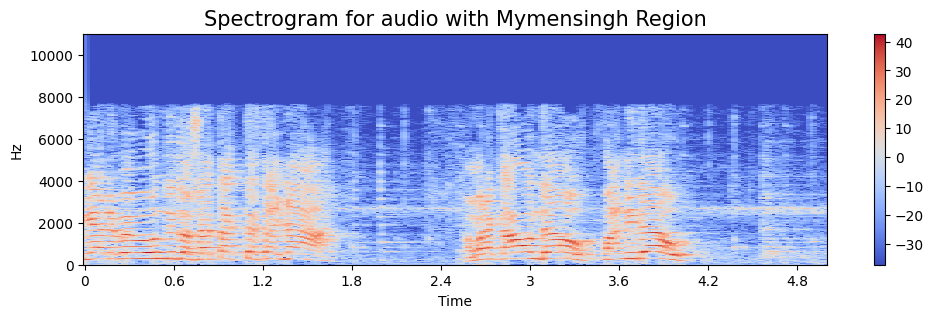

In [ ]:
#Mymensingh
region='Mymensingh'
path = np.array(df.Path[df.Region==region])[0]
data, sampling_rate = librosa.load(path)
create_spectrogram(data, sampling_rate, region)
Audio(path)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

**Data Augmentation**

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(data, sampling_rate, rate=0.7)

# taking any example and checking for techniques.
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))

Audio(x, rate=sample_rate)

<Figure size 1400x400 with 0 Axes>

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))

Audio(x, rate=sample_rate)

<Figure size 1400x400 with 0 Axes>

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))

Audio(x, rate=sample_rate)

<Figure size 1400x400 with 0 Axes>

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    #data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(new_data)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
c=0
for path, region in zip(df.Path, df.Region):
    feature = get_features(path)
    for ele in feature:
        c = c+1
        print(c)
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(region)

Streaming output truncated to the last 5000 lines.
22910
22911
22912
22913
22914
22915
22916
22917
22918
22919
22920
22921
22922
22923
22924
22925
22926
22927
22928
22929
22930
22931
22932
22933
22934
22935
22936
22937
22938
22939
22940
22941
22942
22943
22944
22945
22946
22947
22948
22949
22950
22951
22952
22953
22954
22955
22956
22957
22958
22959
22960
22961
22962
22963
22964
22965
22966
22967
22968
22969
22970
22971
22972
22973
22974
22975
22976
22977
22978
22979
22980
22981
22982
22983
22984
22985
22986
22987
22988
22989
22990
22991
22992
22993
22994
22995
22996
22997
22998
22999
23000
23001
23002
23003
23004
23005
23006
23007
23008
23009
23010
23011
23012
23013
23014
23015
23016
23017
23018
23019
23020
23021
23022
23023
23024
23025
23026
23027
23028
23029
23030
23031
23032
23033
23034
23035
23036
23037
23038
23039
23040
23041
23042
23043
23044
23045
23046
23047
23048
23049
23050
23051
23052
23053
23054
23055
23056
23057
23058
23059
23060
23061
23062
23063
23064
23065
23066
23067
2

In [ ]:
len(X), len(Y), df.Path.shape

(27909, 27909, (9303,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.100826  0.537595  0.553134  0.560478  0.478841  0.426099  0.431611   
1  0.181844  0.609064  0.628681  0.597029  0.533249  0.516754  0.493262   
2  0.103696  0.559023  0.562317  0.492314  0.423350  0.430634  0.450330   
3  0.081489  0.436285  0.483905  0.475792  0.526326  0.566953  0.486595   
4  0.081742  0.437023  0.484608  0.476462  0.527070  0.567603  0.486999   

          7         8         9  ...       153       154       155       156  \
0  0.455918  0.479337  0.494502  ...  0.000006  0.000005  0.000005  0.000004   
1  0.494957  0.516887  0.553183  ...  0.036080  0.037174  0.037214  0.038428   
2  0.467092  0.489528  0.529893  ...  0.000022  0.000021  0.000020  0.000021   
3  0.383117  0.404412  0.453288  ...  0.000005  0.000005  0.000004  0.000004   
4  0.383127  0.404430  0.453232  ...  0.000010  0.000010  0.000009  0.000009   

        157       158       159       160       161  labels  
0  0.000004  0.000004  0.000004  0.000004  0.000004  Shylet  
1  0.039911  0.040425  0.038252  0.037054  0.036488  Shylet  
2  0.000021  0.000020  0.000020  0.000019  0.000019  Shylet  
3  0.000004  0.000004  0.000004  0.000004  0.000004  Shylet  
4  0.000009  0.000009  0.000009  0.000009  0.000009  Shylet  

[5 rows x 163 columns]

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0,test_size = 0.20, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((22327, 162), (22327, 9), (5582, 162), (5582, 9))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((22327, 162), (22327, 9), (5582, 162), (5582, 9))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((22327, 162, 1), (22327, 9), (5582, 162, 1), (5582, 9))

In [ ]:
import tensorflow.keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#approch two DNN (Run This)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.1))
###third layer
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.1))
###fourth layer
model.add(Dense(42))
#model.add(Dropout(0.2))
model.add(Flatten())
###final layer
model.add(Dense(9))
model.add(Activation('softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 100)               16300     
                                                                 
 activation_40 (Activation)  (None, 100)               0         
                                                                 
 dropout_36 (Dropout)        (None, 100)               0         
                                                                 
 dense_51 (Dense)            (None, 200)               20200     
                                                                 
 activation_41 (Activation)  (None, 200)               0         
                                                                 
 dropout_37 (Dropout)        (None, 200)               0         
                                                                 
 dense_52 (Dense)            (None, 300)             

In [ ]:
#approch two ANN (Run This)
#approch two ANN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.1))
###third layer
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.1))
###fourth layer
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Flatten())
###final layer
model.add(Dense(9))
model.add(Activation('softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 100)               16300     
                                                                 
 activation_63 (Activation)  (None, 100)               0         
                                                                 
 dropout_48 (Dropout)        (None, 100)               0         
                                                                 
 dense_62 (Dense)            (None, 200)               20200     
                                                                 
 activation_64 (Activation)  (None, 200)               0         
                                                                 
 dropout_49 (Dropout)        (None, 200)               0         
                                                                 
 dense_63 (Dense)            (None, 300)             

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.5, verbose=0, patience=2, min_lr=0.0000001)

In [ ]:
history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
349/349 [==============================] - 5s 6ms/step - loss: 1.1991 - accuracy: 0.5798 - val_loss: 0.8735 - val_accuracy: 0.6929 - lr: 0.0010
Epoch 2/100
349/349 [==============================] - 2s 5ms/step - loss: 0.8432 - accuracy: 0.7012 - val_loss: 0.7104 - val_accuracy: 0.7522 - lr: 0.0010
Epoch 3/100
349/349 [==============================] - 2s 5ms/step - loss: 0.7027 - accuracy: 0.7506 - val_loss: 0.6405 - val_accuracy: 0.7716 - lr: 0.0010
Epoch 4/100
349/349 [==============================] - 2s 5ms/step - loss: 0.6125 - accuracy: 0.7804 - val_loss: 0.5653 - val_accuracy: 0.8004 - lr: 0.0010
Epoch 5/100
349/349 [==============================] - 2s 5ms/step - loss: 0.5606 - accuracy: 0.7982 - val_loss: 0.5369 - val_accuracy: 0.8117 - lr: 0.0010
Epoch 6/100
349/349 [==============================] - 2s 4ms/step - loss: 0.5093 - accuracy: 0.8142 - val_loss: 0.4779 - val_accuracy: 0.8296 - lr: 0.0010
Epoch 7/100
349/349 [==============================] - 2s 5ms/st

175/175 [==============================] - 0s 3ms/step - loss: 0.2064 - accuracy: 0.9353
Accuracy of our model on test data :  93.53278279304504 %


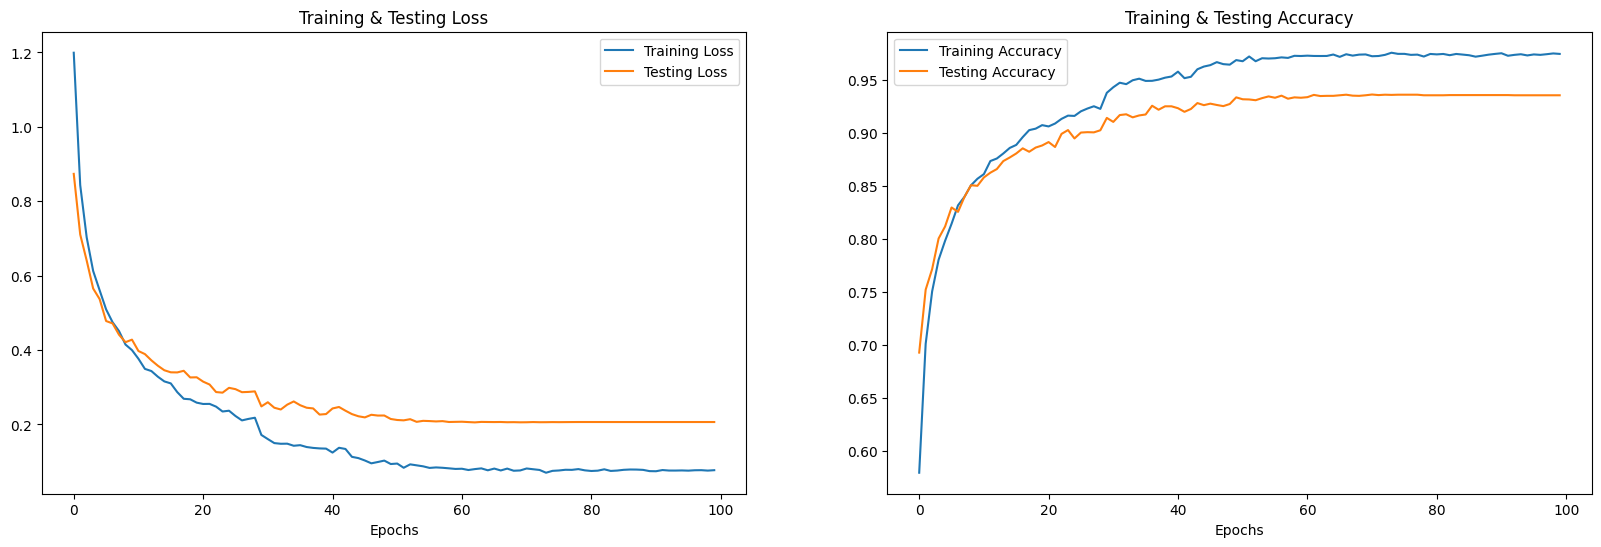

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test1 = encoder.inverse_transform(y_test)

175/175 [==============================] - 0s 2ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test1.flatten()

df.tail(20)

Predicted Labels Actual Labels
5562         Noakhali      Noakhali
5563         Barishal      Noakhali
5564         Rajshahi      Rajshahi
5565       Mymensingh    Mymensingh
5566         Noakhali      Noakhali
5567         Barishal      Barishal
5568           Shylet        Shylet
5569           Shylet        Shylet
5570       Chottogram    Chottogram
5571         Rajshahi      Rajshahi
5572         Noakhali        Khulna
5573         Rajshahi      Rajshahi
5574         Barishal      Barishal
5575         Barishal      Barishal
5576         Noakhali      Noakhali
5577            Dhaka         Dhaka
5578         Noakhali      Noakhali
5579           Khulna        Khulna
5580            Dhaka         Dhaka
5581       Chottogram    Chottogram

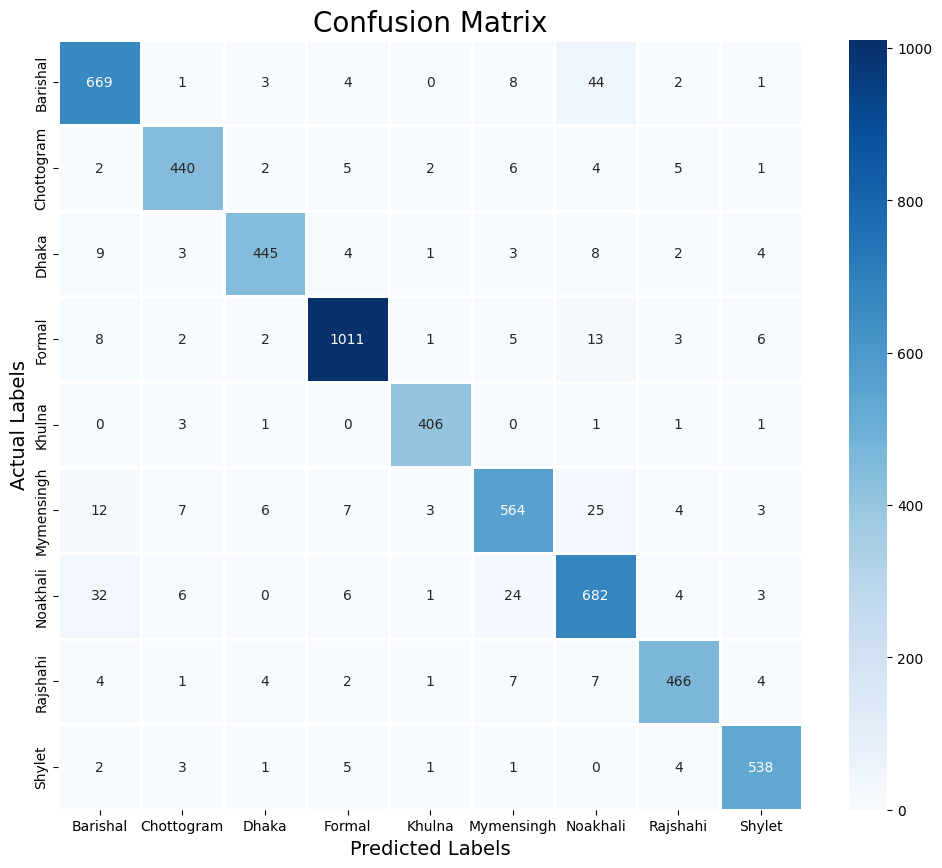

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test1, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test1, y_pred))

              precision    recall  f1-score   support

    Barishal       0.91      0.91      0.91       732
  Chottogram       0.94      0.94      0.94       467
       Dhaka       0.96      0.93      0.94       479
      Formal       0.97      0.96      0.97      1051
      Khulna       0.98      0.98      0.98       413
  Mymensingh       0.91      0.89      0.90       631
    Noakhali       0.87      0.90      0.88       758
    Rajshahi       0.95      0.94      0.94       496
      Shylet       0.96      0.97      0.96       555

    accuracy                           0.94      5582
   macro avg       0.94      0.94      0.94      5582
weighted avg       0.94      0.94      0.94      5582

